In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy import stats
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.datasets import make_regression
import sklearn
from sklearn.model_selection import GridSearchCV
np.random.seed(10)

# Carga de los df de features para entrenar y predecir

In [57]:
windows = ["18_20","19_21","20_22","21_23"]
features = {}
label_auc = {}
label_inst = {}
label_clas_auc = {}
label_clas_inst = {}

for window in windows:
    features[window] = pd.read_csv("windows/{}/features.csv".format(window), index_col="ref_hash")
    label_auc[window] = pd.read_csv("windows/{}/labels_auc.csv".format(window), index_col="ref_hash")
    label_inst[window] = pd.read_csv("windows/{}/labels_inst.csv".format(window), index_col="ref_hash")
    label_clas_auc[window] = pd.DataFrame({'ref_hash': label_auc[window].index, 'label_auc': (label_auc[window]['label_auc'] == 259200).astype(int)}).set_index("ref_hash")
    label_clas_inst[window] = pd.DataFrame({'ref_hash': label_inst[window].index, 'label_inst': (label_inst[window]['label_inst'] == 259200).astype(int)}).set_index("ref_hash")
    
features_to_predict = pd.read_csv("windows/24_26/features.csv", index_col="ref_hash") 

# Funciones de entrenamiento

In [58]:
def guardar_submit(params, result):
    tiempo = "time"
    with open("historial_submits.txt","a+") as f:
        f.write("\n"+tiempo+"|"+params+"|")

In [59]:
def entrenar(modelo, df_features, labels):
    df_features = df_features.merge(labels, how="left", left_on="ref_hash", right_on="ref_hash")
    df_features.set_index("ref_hash", inplace=True)
    X, y = df_features.iloc[:,:-1], df_features.iloc[:,-1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)
    
    modelo.fit(X_train, y_train, eval_metric='rmse')

    prediction = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, prediction))
    print("RMSE: %f" % (rmse))
    return prediction

## Selección de features

In [60]:
def select_features(df, feature_list):
    return df.reindex(columns=feature_list)

In [67]:
features_list_class_auc = [
    'appearances_in_auctions', 
    'user_appeared_last_day', 
    'time_to_reappear',
    #'amount_of_clicks', 
    'has_installed', 
    #'user_clicked_last_day',
    'user_installed_last_day', 
    'amount_of_installs', 
    #'cant_max_day',
    #'cant_min_day', 
    #'mean_time_to_click', 
    #'max_time_click',
    #'min_time_click', 
    'mean_auctions_per_day', 
    'mean_events_per_day',
    #'mean_clicks_per_day', 
    'amount_auctions_in_last_hour',
    'amount_auctions_in_last_2_hours', 
    'amount_auctions_in_last_5_hours',
    'amount_auctions_in_last_12_hours', 
    'amount_auctions_in_last_24_hours',
    #'amount_events_in_last_hour', 
    'amount_events_in_last_2_hours',
    'amount_auctions_in_first_hour', 
    'amount_auctions_in_first_3_hours',
    'amount_auctions_in_first_5_hours', 
    'amount_auctions_in_first_12_hours',
    'amount_events_in_first_hour', 
    'amount_events_in_first_5_hours',
    'amount_events_in_first_12_hours', 
    #'amount_clicks_in_last_2_hours',
    #'amount_clicks_in_last_4_hours', 
    'device_os', 
    #'std_time_to_click',
    'std_time_auctions', 
    'max_time_install', 
    'min_time_install',
    'mean_time_install', 
    #'std_time_install', 
    'max_time_events',
    'min_time_events', 
    'mean_time_events', 
    'std_time_events',
    #'installs_per_events', 
    #'installs_per_clicks', 
    'events_x_app_210',
    'events_x_app_122', 
    'events_x_app_65', 
    'events_x_app_121',
    'events_x_app_26', 
    'most_installed_apps_used', 
    'cant_apps_used',
    #'cant_events_atributed', 
    #'has_events_atributed',
    #'has_events_ids_with_installs', 
    #'has_events_ids_without_installs',
    'cant_events_0_4', 
    'cant_events_4_8', 
    'cant_events_8_12',
    'cant_events_12_16', 
    'cant_events_16_20', 
    'cant_events_20_24',
    'cant_auctions_0_4', 
    'cant_auctions_4_8', 
    'cant_auctions_8_12',
    'cant_auctions_12_16', 
    'cant_auctions_16_20', 
    'cant_auctions_20_24',
    'implicit', 
    #'latitude', 
    #'longitude', 
    #'clicked_in_last_5_minutes',
    #'clicked_with_wifi_in_last_3_hours', 
    'hour_install', 
    'hour_events',
    #'hour_clicks', 
    'hour_auctions'
]

In [66]:
features_list_class_inst = [
    'appearances_in_auctions', 
    'user_appeared_last_day', 
    'time_to_reappear',
    'amount_of_clicks', 
    'has_installed', 
    'user_clicked_last_day',
    'user_installed_last_day', 
    'amount_of_installs', 
    #'cant_max_day',
    #'cant_min_day', 
    #'mean_time_to_click', 
    #'max_time_click',
    #'min_time_click', 
    'mean_auctions_per_day', 
    'mean_events_per_day',
    #'mean_clicks_per_day', 
    'amount_auctions_in_last_hour',
    'amount_auctions_in_last_2_hours', 
    'amount_auctions_in_last_5_hours',
    'amount_auctions_in_last_12_hours', 
    'amount_auctions_in_last_24_hours',
    'amount_events_in_last_hour', 
    'amount_events_in_last_2_hours',
    'amount_auctions_in_first_hour', 
    'amount_auctions_in_first_3_hours',
    'amount_auctions_in_first_5_hours', 
    'amount_auctions_in_first_12_hours',
    'amount_events_in_first_hour', 
    'amount_events_in_first_5_hours',
    'amount_events_in_first_12_hours', 
    #'amount_clicks_in_last_2_hours',
    #'amount_clicks_in_last_4_hours', 
    'device_os', 
    #'std_time_to_click',
    'std_time_auctions', 
    'max_time_install', 
    'min_time_install',
    'mean_time_install', 
    'std_time_install', 
    'max_time_events',
    'min_time_events', 
    'mean_time_events', 
    'std_time_events',
    'installs_per_events', 
    #'installs_per_clicks', 
    'events_x_app_210',
    'events_x_app_122', 
    'events_x_app_65', 
    'events_x_app_121',
    'events_x_app_26', 
    'most_installed_apps_used', 
    'cant_apps_used',
    'cant_events_atributed', 
    #'has_events_atributed',
    #'has_events_ids_with_installs', 
    'has_events_ids_without_installs',
    'cant_events_0_4', 
    'cant_events_4_8', 
    'cant_events_8_12',
    'cant_events_12_16', 
    'cant_events_16_20', 
    'cant_events_20_24',
    'cant_auctions_0_4', 
    'cant_auctions_4_8', 
    'cant_auctions_8_12',
    'cant_auctions_12_16', 
    'cant_auctions_16_20', 
    'cant_auctions_20_24',
    'implicit', 
    'latitude', 
    'longitude', 
    #'clicked_in_last_5_minutes',
    'clicked_with_wifi_in_last_3_hours', 
    'hour_install', 
    'hour_events',
    'hour_clicks', 
    'hour_auctions'
]

# Modelos

## Clasificador

In [68]:
def get_df_to_train(windows, features, labels, feature_list):
    df_list = []
    for window in windows:
        df = select_features(features[window], feature_list).join(labels[window], how="inner")
        df_list.append(df)
    df_full = pd.concat(df_list)
    df_full.reset_index(inplace=True, drop=True)
    return df_full

In [69]:
# factor = 1 100% balanced
# factor = 0 not balanced
# label_value label que mas aparece y se debe balancear
def balance(df_full, label_name, factor, label_value = 1):
    cant_values = df_full[label_name].value_counts()[label_value]
    cant_no_values = len(df_full[label_name]) - cant_values
    a_borrar = int((cant_values-cant_no_values)*factor)
    index_to_drop = np.random.choice(df_full.loc[df_full[label_name] == label_value].index,a_borrar, replace=False)
    return df_full.drop(index=index_to_drop)

In [70]:
def get_train_test_split(df_full, label_name, test_size=0.3):
    y = df_full[label_name]
    X_data = df_full.drop(label_name, axis=1)
    return train_test_split(X_data, y, test_size=test_size, random_state=7)

### Clasificador installs

In [250]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [253]:
df_full = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full = df_full.fillna(0)
df_full = df_full[df_full["label_auc"] < 259200]

In [182]:
#df_full['label'] = np.where(df_full['label_inst']<259200, 1, 0)
#df_full.drop(labels="label_inst", axis=1, inplace=True)

In [200]:
#df_full = df_full.sample(, replace=True).fillna(0)

In [196]:
#Y = df_full["label_inst"]
#X = df_full.drop(labels="label_inst", axis=1)

In [254]:
X_train, X_test, y_train, y_test = get_train_test_split(df_full, "label_auc")

In [255]:
from keras import metrics
model_auc_neural = Sequential()
model_auc_neural.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model_auc_neural.add(Dense(30, activation='relu'))
model_auc_neural.add(Dropout(0.2))
model_auc_neural.add(Dense(40, activation='relu'))
model_auc_neural.add(Dropout(0.2))
model_auc_neural.add(Dense(1))
# Compile model
model_auc_neural.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])
model_auc_neural.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=4, batch_size=32)

Train on 704627 samples, validate on 301984 samples
Epoch 1/4
116736/704627 [===>..........................] - ETA: 39s - loss: 7683660852.0702 - mean_absolute_error: 62878.0344

KeyboardInterrupt: 

In [246]:
model_auc_neural.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 10)                650       
_________________________________________________________________
dense_91 (Dense)             (None, 40)                440       
_________________________________________________________________
dense_92 (Dense)             (None, 1)                 41        
Total params: 1,131
Trainable params: 1,131
Non-trainable params: 0
_________________________________________________________________


In [224]:
df_full_inst = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_full_inst = df_full_inst.fillna(0)
df_full_inst = df_full_inst[df_full_inst["label_inst"] < 259200]
X_train, X_test, y_train, y_test = get_train_test_split(df_full_inst, "label_inst")

In [225]:
from keras import metrics
model_inst_neural = Sequential()
model_inst_neural.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model_inst_neural.add(Dense(30, activation='relu'))
model_inst_neural.add(Dense(40, activation='relu'))
model_inst_neural.add(Dense(1))
# Compile model
model_inst_neural.compile(optimizer ='adam', loss = 'mean_squared_error', metrics =[metrics.mae])
model_inst_neural.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=10, batch_size=32)

Train on 157881 samples, validate on 67664 samples
Epoch 1/10
157881/157881 [==============================] - 10s 63us/step - loss: 14752886331.5178 - mean_absolute_error: 98970.0606 - val_loss: 13584439046.5982 - val_mean_absolute_error: 94767.5486
Epoch 2/10
157881/157881 [==============================] - 9s 55us/step - loss: 11018342285.0699 - mean_absolute_error: 85204.8565 - val_loss: 9314918631.9678 - val_mean_absolute_error: 78872.2298
Epoch 3/10
157881/157881 [==============================] - 9s 59us/step - loss: 8783360515.5381 - mean_absolute_error: 77112.7844 - val_loss: 8484113243.5886 - val_mean_absolute_error: 76161.2825
Epoch 4/10
157881/157881 [==============================] - 9s 57us/step - loss: 8441227519.3303 - mean_absolute_error: 75981.8345 - val_loss: 8363479943.4155 - val_mean_absolute_error: 75785.4486
Epoch 5/10
157881/157881 [==============================] - 9s 59us/step - loss: 8225939858.0446 - mean_absolute_error: 75226.4070 - val_loss: 8294716741.796

In [222]:
a

array([[90473.05 ],
       [ 6604.288],
       [50049.824],
       ...,
       [93581.266],
       [93581.266],
       [93581.266]], dtype=float32)

In [162]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 4,225
Trainable params: 4,225
Non-trainable params: 0
_________________________________________________________________


In [ ]:
features_list = features_list_class_inst
df_full = get_df_to_train(windows, features, label_clas_inst, features_list)

df_full = balance(df_full, "label_inst", 1, 1)

X_train, X_test, y_train, y_test = get_train_test_split(df_full, "label_inst")

model_class_inst = xgb.XGBClassifier()
train_model_class = model_class_inst.fit(X_train, y_train)
pred_model_class = train_model_class.predict(X_test)
print("Accuracy for model installs: %.2f" % (accuracy_score(y_test, pred_model_class) * 100))
print("Using features: "+str(features_list))

In [ ]:
pd.Series(pred_model_class).value_counts()

In [ ]:
y_test.value_counts()

In [ ]:
df_full["label_inst"].value_counts()

### Clasificador auctions

In [ ]:
df_full = get_df_to_train(windows, features, label_clas_auc, features_list_class_auc)

df_full = balance(df_full, "label_auc", 1, 1)

X_train, X_test, y_train, y_test = get_train_test_split(df_full, "label_auc")

model_class_auc = xgb.XGBClassifier()
train_model_class = model_class_auc.fit(X_train, y_train)
pred_model_class = train_model_class.predict(X_test)
print("Accuracy for model auctions: %.2f" % (accuracy_score(y_test, pred_model_class) * 100))
print("Using features: "+str(features_list_class_auc))

# Importancia de los features

In [63]:
from sklearn.datasets import load_boston
from sklearn.ensemble import RandomForestRegressor

## Auctions

In [64]:
df_auctions_importance = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_auctions_importance = df_auctions_importance.sample(10000)


df_auctions_features = df_auctions_importance.drop('label_auc', axis=1)
df_auctions_labels = df_auctions_importance['label_auc']

X = df_auctions_features.fillna(0)
Y = df_auctions_labels
names = X.columns.tolist()
rf = RandomForestRegressor()
rf.fit(X, Y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Features sorted by their score:
[(0.2975, 'std_time_auctions'), (0.1368, 'time_to_reappear'), (0.0591, 'amount_auctions_in_last_24_hours'), (0.0583, 'hour_auctions'), (0.0494, 'appearances_in_auctions'), (0.0356, 'mean_auctions_per_day'), (0.0213, 'cant_auctions_20_24'), (0.0204, 'cant_auctions_16_20'), (0.0188, 'hour_install'), (0.0187, 'cant_auctions_12_16'), (0.0175, 'hour_events'), (0.017, 'cant_auctions_4_8'), (0.0169, 'min_time_events'), (0.016, 'amount_auctions_in_first_5_hours'), (0.0144, 'amount_auctions_in_first_hour'), (0.0137, 'amount_auctions_in_first_12_hours'), (0.0133, 'amount_auctions_in_last_12_hours'), (0.0114, 'max_time_events'), (0.011, 'mean_time_events'), (0.0101, 'amount_auctions_in_last_2_hours'), (0.0089, 'std_time_events'), (0.0084, 'cant_auctions_0_4'), (0.0081, 'amount_auctions_in_last_5_hours'), (0.0079, 'amount_auctions_in_first_3_hours'), (0.007, 'mean_events_per_day'), (0.0068, 'cant_auctions_8_12'), (0.0062, 'installs_per_events'), (0.0051, 'cant_event

## Installs

In [65]:
df_installs_importance = get_df_to_train(windows, features, label_inst, features_list_class_inst)
df_installs_importance = df_installs_importance.sample(10000)


df_installs_features = df_installs_importance.drop('label_inst', axis=1)
df_installs_labels = df_installs_importance['label_inst']

X = df_installs_features.fillna(0)
Y = df_installs_labels
names = X.columns.tolist()
rf = RandomForestRegressor(n_estimators=50)
rf.fit(X, Y)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True))

Features sorted by their score:
[(0.1405, 'time_to_reappear'), (0.1015, 'hour_auctions'), (0.1004, 'std_time_auctions'), (0.0429, 'mean_auctions_per_day'), (0.0389, 'appearances_in_auctions'), (0.0349, 'amount_auctions_in_last_24_hours'), (0.0339, 'cant_auctions_16_20'), (0.0331, 'cant_auctions_12_16'), (0.0295, 'cant_auctions_4_8'), (0.0286, 'cant_auctions_20_24'), (0.0269, 'amount_auctions_in_first_12_hours'), (0.0258, 'amount_auctions_in_first_5_hours'), (0.0247, 'amount_auctions_in_first_hour'), (0.023, 'amount_auctions_in_last_12_hours'), (0.0192, 'min_time_events'), (0.0182, 'amount_auctions_in_first_3_hours'), (0.0181, 'hour_events'), (0.0172, 'amount_auctions_in_last_5_hours'), (0.0171, 'cant_auctions_0_4'), (0.0166, 'cant_auctions_8_12'), (0.0144, 'has_installed'), (0.0136, 'amount_of_installs'), (0.0131, 'max_time_events'), (0.0131, 'amount_auctions_in_last_2_hours'), (0.013, 'amount_auctions_in_last_hour'), (0.0125, 'mean_time_events'), (0.0107, 'mean_events_per_day'), (0.00

## Modelos de predicción de tiempos

### Modelo auction

In [71]:
df_full = get_df_to_train(windows, features, label_auc, features_list_class_auc)

df_full = df_full.sample(int(len(df_full)))

#df_full = balance(df_full, "label_auc", 0, 259200)

df_full = df_full.loc[df_full["label_auc"] != 259200]

X_train, X_test, y_train, y_test = get_train_test_split(df_full, "label_auc", 0.2)

In [72]:
model_auc = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1,
    colsample_bytree=1, 
    gamma=0.1, 
    learning_rate=0.1, 
    max_delta_step=0,
    max_depth=4, 
    min_child_weight=1, 
    missing=None, 
    n_estimators=600,
    n_jobs=1, 
    nthread=None, 
    objective='reg:linear', 
    random_state=0,
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    seed=None,
    silent=True, 
    subsample=1
)

In [73]:
%%time
model_auc.fit(X_train, y_train, eval_metric='rmse')
#cv = xgb.cv(params, xg_train, 5000, nfold=n_folds, early_stopping_rounds=early_stopping, verbose_eval=1)
prediction = model_auc.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE: %f" % (rmse))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RMSE: 63345.641573
CPU times: user 25min 48s, sys: 8.65 s, total: 25min 57s
Wall time: 26min 8s


RMSE: 63345.641573
CPU times: user 25min 48s, sys: 8.65 s, total: 25min 57s
Wall time: 26min 8s
    
model_auc = xgb.XGBRegressor(
    base_score=0.5, 
    booster='gbtree', 
    colsample_bylevel=1,
    colsample_bytree=1, 
    gamma=0.1, 
    learning_rate=0.1, 
    max_delta_step=0,
    max_depth=4, 
    min_child_weight=1, 
    missing=None, 
    n_estimators=600,
    n_jobs=1, 
    nthread=None, 
    objective='reg:linear', 
    random_state=0,
    reg_alpha=0, 
    reg_lambda=1, 
    scale_pos_weight=1, 
    seed=None,
    silent=True, 
    subsample=1
)

In [ ]:
_ = plot_importance(model_auc, height=0.5)

In [ ]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(model_auc, height=0.5)

### Modelo installs

In [88]:
df_full_installs = get_df_to_train(windows, features, label_inst, features_list_class_inst)

df_full_installs = df_full_installs.sample(int(len(df_full_installs)*0.5))

df_full_installs = balance(df_full_installs, "label_inst", 1, 259200)
#df_full_installs = df_full_installs[df_full_installs["label_inst"] != 259200]

X_train, X_test, y_train, y_test = get_train_test_split(df_full_installs, "label_inst", 0.2)

In [89]:
model_inst = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators=500,
    max_dept=5,
    gamma=0.1,
    n_jobs=-1
)

In [90]:
%%time
model_inst.fit(X_train, y_train, eval_metric='rmse', verbose=True)

prediction = model_inst.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print("RMSE: %f" % (rmse))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[03:28:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 81427.840998
CPU times: user 4min 1s, sys: 1.27 s, total: 4min 3s
Wall time: 4min 4s


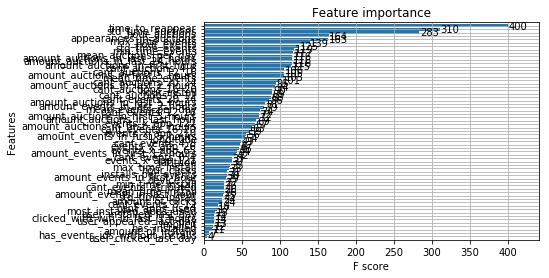

In [77]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(model_inst, height=0.9)

WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 76768.119164
CPU times: user 5min 39s, sys: 2 s, total: 5min 41s
Wall time: 5min 44s

model_inst = xgb.XGBRegressor(
    learning_rate = 0.1,
    n_estimators=700,
    max_dept=5,
    gamma=0.1,
    n_jobs=-1
)"

# Predecir

### Predicción auctions

In [231]:
pred_auctions = model_auc_neural.predict(select_features(features_to_predict, features_list_class_auc).fillna(0))

pred_auctions = np.array(pred_auctions).flatten()
df_preds_auctions = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_auctions})
#df_preds_auctions.to_csv("auctions_predictions.csv", index=False) #persistimos los resultados

In [230]:
np.array(pred_auctions).flatten()

array([81804.68  ,  5382.7695, 44997.797 , ..., 78190.15  , 78190.15  ,
       78190.15  ], dtype=float32)

### Predicción installs

In [236]:
pred_installs = model_inst_neural.predict(select_features(features_to_predict, features_list_class_inst).fillna(0))

pred_installs = np.array(pred_installs).flatten()
df_preds_installs = pd.DataFrame({'ref_hash' : features_to_predict.index, 'obj' : pred_installs})
#df_preds_installs.to_csv("installs_predictions.csv", index=False) #persistimos los resultados

In [ ]:
pred_clas_inst = model_class_inst.predict(features_to_predict)

df_preds_installs = pd.DataFrame({"ref_hash":features_to_predict.index,"obj":pred_clas_inst})
ref_not_to_predict = []#df_preds_installs.loc[df_preds_installs["obj"] == 1]["ref_hash"].unique()

df_to_predict = features_to_predict.drop(index=ref_to_predict)

pred_installs = model_inst.predict(df_to_predict.reset_index(drop=True))

df_pred_value = pd.DataFrame({"ref_hash":df_to_predict.index,"value":pred_installs})

df_preds_installs = df_preds_installs.merge(df_pred_value,left_on="ref_hash",right_on="ref_hash",how="left")
df_preds_installs["obj"] = df_preds_installs["value"]
del df_preds_installs["value"]
df_preds_installs = df_preds_installs.fillna(259200)

df_preds_installs.to_csv("installs_predictions.csv", index=False) #persistimos los resultados

# Parameter Tuning

In [ ]:
df_full = get_df_to_train(windows, features, label_auc, features_list_class_auc)
df_full = df_full.sample(int(len(df_full)*0.1))
df_full = df_full[df_full["label_auc"] != 259200]

### Max_depth and min_child_weight tuning

In [ ]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch1.fit(df_full[features_list_class_auc],df_full['label_auc'])
#gsearch1.cv_results_

In [ ]:
np.sqrt(gsearch1.best_score_ * (-1))

In [ ]:
gsearch1.best_params_

> #### Refinamos la búsqueda entre valores acotados

In [ ]:
param_test2 = {
 'max_depth': [3,4,5],
 'min_child_weight': [3,4,5]
}
gsearch2 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.01, n_estimators=1000, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch2.fit(df_full[features_list_class_auc],df_full['label_auc'])
#gsearch2.cv_results_

In [ ]:
gsearch2.best_params_  #los mejores parámetros son max_depth 4 y min child_weight 3

In [ ]:
np.sqrt(gsearch2.best_score_ * (-1))

### Learning rate and n_estimators tunning

In [ ]:
param_test3 = {
    'n_estimators' : [100,200,500, 1000],
    'learning_rate' : [0.1, 0.05, 0.01]
}
gsearch3 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=140, max_depth=3,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test3, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch3.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch3.best_params_

In [ ]:
np.sqrt(gsearch3.best_score_ * (-1))

### Gamma tuning

In [ ]:
param_test4 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch4 = GridSearchCV(estimator = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring= 'neg_mean_squared_error', n_jobs=4,iid=False, cv=5)
gsearch4.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch4.best_params_

In [ ]:
np.sqrt(gsearch4.best_score_ * (-1))

### Subsample and colsample_bytree tuning

In [ ]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBRegressor( learning_rate = 0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch5.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch5.best_params_

In [ ]:
np.sqrt(gsearch5.best_score_ * (-1))

### Regularization tuning

In [ ]:
param_test6 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch6 = GridSearchCV(estimator = XGBRegressor( learning_rate = 0.1, n_estimators=200, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.9, colsample_bytree=0.7,
 objective= 'reg:squarederror', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='neg_mean_squared_error',n_jobs=4,iid=False, cv=5)
gsearch6.fit(df_full[features_list_class_auc],df_full['label_auc'])

In [ ]:
gsearch6.best_params_

In [ ]:
np.sqrt(gsearch6.best_score_ * (-1))

# Submit to Kaggle

In [237]:
def export_df(df, name):
    df.to_csv(name, index=False)

Las predicciones tendrán seteadas como índice los ref_hash para no perder la referencia
No es necesario filtrar los ref_hash y quedarnos solo con los target en las predicciones que obtenemos ya que de eso
se encarga la función 

In [238]:
target = pd.read_csv("target_competencia_ids.csv")

In [239]:
#df_preds_installs = pd.read_csv("installs_predictions.csv")
#df_preds_auctions = pd.read_csv("auctions_predictions.csv")

In [240]:
def create_submit_df(auctions_predictions, installs_predictions, target):
    
    target = target.set_index('ref_hash')
    
    auc = auctions_predictions.reset_index()
    auc.columns = ['ref_hash','obj']
    auc['ref_hash'] = auc['ref_hash'].astype(str) + "_st"
    auc = auc.set_index('ref_hash')
    
    ins = installs_predictions.reset_index()
    ins.columns = ['ref_hash','obj']
    ins['ref_hash'] = ins['ref_hash'].astype(str) + "_sc"
    ins = ins.set_index('ref_hash')
    
    frames = [ins,auc]
    submit_result = pd.concat(frames).reset_index()
    target_list = target.reset_index('ref_hash')['ref_hash'].tolist()
    return submit_result.loc[submit_result['ref_hash'].isin(target_list)].sort_values(by = 'ref_hash')

In [241]:
kaggle_sub = create_submit_df(df_preds_auctions.set_index('ref_hash'), \
                              df_preds_installs.set_index('ref_hash'), target)

In [242]:
export_df(kaggle_sub, "submit.csv")